# Lesson 03 Assignment
Author: Ajai Shukla
Description:
Using the Superstore Transaction dataset, create a new notebook and perform each of the following tasks and answer the related questions:

Read dataset
Calculate the Recency, Frequency, Monitory for each customer
Using K-means algorithm, perform customer segmentation
Describe your results

In [107]:

# importing all the packages required for the data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from IPython.display import display, HTML

In [108]:
# loading the dataset:
df = pd.read_csv(r'C:\Users\ashukla\Documents\DS\SuperstoreTransaction.csv', encoding="ISO-8859-1",dtype={'OrderID': str})                      


In [109]:

print(df.head(10))
# looking at the shape of the dataset
df.shape

   RowID         OrderID   OrderDate    ShipDate        ShipMode CustomerID  \
0      1  CA-2016-152156   11/8/2016  11/11/2016    Second Class   CG-12520   
1      2  CA-2016-152156   11/8/2016  11/11/2016    Second Class   CG-12520   
2      3  CA-2016-138688   6/12/2016   6/16/2016    Second Class   DV-13045   
3      4  US-2015-108966  10/11/2015  10/18/2015  Standard Class   SO-20335   
4      5  US-2015-108966  10/11/2015  10/18/2015  Standard Class   SO-20335   
5      6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   BH-11710   
6      7  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   BH-11710   
7      8  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   BH-11710   
8      9  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   BH-11710   
9     10  CA-2014-115812    6/9/2014   6/14/2014  Standard Class   BH-11710   

      CustomerName    Segment        Country             City    ...     \
0      Claire Gute   Consumer  United States        Hen

(9994, 21)

# Data Explorations:
Columns Description :

OrderID : Unique ID for every time a consumer visits the store
ShipMode: Unique ID for a product
Description : Description of the product
Quantity : No of units bought
IOrderDate : Date and time of purchase
Sales : Price for 1 unit of the product
CustomerId : Unique ID for each customer
Country : Country where transaction happened
Also for our analysis we need to calculate the total sales for each product by multiplying Quantity with Unit Price. Also, convert Invoice Date in YYYYMM format.

In [110]:
df['Total_Price'] = df['Sales']*df['Quantity']

tst = df.groupby(['OrderDate','OrderID'])
        
tst.size()

# converting 
df['date'] =pd.to_datetime(df['OrderDate']).map(lambda x: 100*x.year + x.month)

tst = df.groupby(['date'])
tst.size()

date
201401     79
201402     46
201403    157
201404    135
201405    122
201406    135
201407    143
201408    153
201409    268
201410    159
201411    318
201412    278
201501     58
201502     64
201503    138
201504    160
201505    146
201506    138
201507    140
201508    159
201509    293
201510    166
201511    324
201512    316
201601     89
201602     83
201603    163
201604    170
201605    225
201606    199
201607    201
201608    176
201609    363
201610    196
201611    370
201612    352
201701    155
201702    107
201703    238
201704    203
201705    242
201706    245
201707    226
201708    218
201709    459
201710    298
201711    459
201712    462
dtype: int64

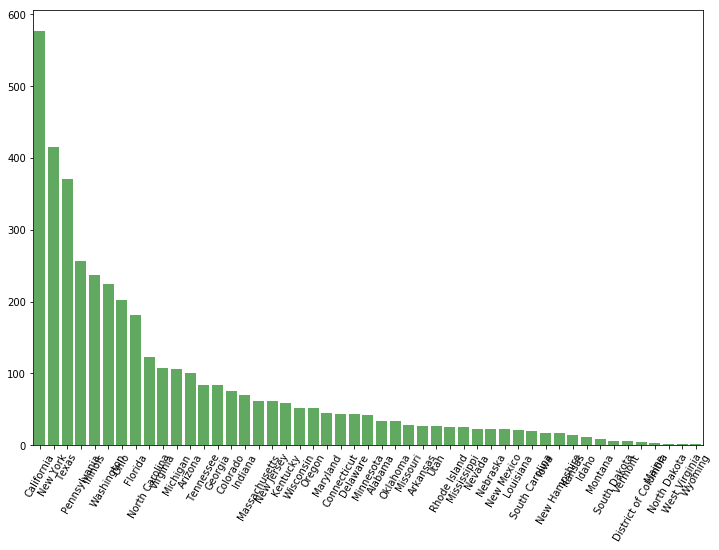

In [111]:
# checking State-wise sales 
Cust_state=df[['State','CustomerID']].drop_duplicates()

#Calculating the distinct count of customer for each State
Cust_state_count=Cust_state.groupby(['State'])['CustomerID'].\
aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

#Plotting the count of customers
state=list(Cust_state_count['State'])
Cust_id=list(Cust_state_count['CustomerID'])
plt.figure(figsize=(12,8))
sns.barplot(state, Cust_id, alpha=0.8, color=color[2])
plt.xticks(rotation='60')
plt.show()


# RFM (Recency, Frequency, Monetary) analysis
RFM criterion is one of the oldest and most widely used technique for selecting the most significant customers. It supports the selection of customers that are most recent (R), frequent (F), and add a larger monetary value (M) in every transaction.

Recency (R): Recency is the most important predictor of who is more likely to respond to an offer. Customers who have purchased recently are more likely to purchase again when compared to those who did not purchase recently. To tag the customers on the basis of recency flag, we will first filter the customers of United Kingdom and take distinct dates of their purchase.

In [112]:
Cust_date_US=df[df['State']=='California']
Cust_date_US=Cust_date_US[['CustomerID','date']].drop_duplicates()

In [113]:

def recency(row):
    if row['date']>201710:
        val = 5
    elif row['date'] <= 201710 and row['date'] > 201708:
        val = 4
    elif row['date'] <= 201706 and row['date'] > 201704:
        val = 3
    elif row['date'] <= 201704 and row['date'] > 201702:
        val = 2
    else:
        val = 1
    return val

Cust_date_US['Recency_Flag'] = Cust_date_US.apply(recency, axis=1)
Cust_date_US.head()

,CustomerID,date,Recency_Flag
2,DV-13045,201606,1
5,BH-11710,201406,1
18,ZD-21925,201408,1
25,EH-13945,201601,1
42,RA-19885,201607,1


In [114]:
tst = Cust_date_US.groupby('Recency_Flag')
tst.size()

Recency_Flag
1    745
2     50
3     49
4     74
5     89
dtype: int64

# Frequency (F):
The second most important factor is how frequently these customers purchase. The higher the frequency, the higher is the chances of these responding to the offers. To tag the customers on the basis of frequency flag, we will take State wise count of distinct Order number for each customer and then filter out the customers of California States. After that, Order count will be split into 5 equal parts to rank the customers on a scale of 1 to 5 where 5 being the most frequent.

In [115]:
Cust_freq=df[['State','OrderID','CustomerID']].drop_duplicates()
Cust_freq.head()

#Calculating the count of unique purchase for each customer and his buying freq in descending order
Cust_freq_count=Cust_freq.groupby(['State','CustomerID'])['OrderID'].aggregate('count').\
reset_index().sort_values('OrderID', ascending=False)


Cust_freq_count_CA=Cust_freq_count[Cust_freq_count['State']=='California']
Cust_freq_count_CA.head()
unique_invoice=Cust_freq_count_CA[['OrderID']].drop_duplicates()

In [116]:
# Dividing in 5 equal parts
unique_invoice['Freqency_Band'] = pd.qcut(unique_invoice['OrderID'], 5)
unique_invoice=unique_invoice[['Freqency_Band']].drop_duplicates()
unique_invoice

,Freqency_Band
504,"(5.0, 6.0]"
183,"(4.0, 5.0]"
420,"(3.0, 4.0]"
286,"(2.0, 3.0]"
658,"(0.999, 2.0]"


In [117]:
def frequency(row):
    if row['OrderID'] <= 2.0:
        val = 1
    elif row['OrderID'] > 2.0 and row['OrderID'] <= 3.0:
        val = 2
    elif row['OrderID'] > 3.0 and row['OrderID'] <= 4.0:
        val = 3
    elif row['OrderID'] > 4.0 and row['OrderID'] <= 5.0:
        val = 4
    else:
        val = 5
    return val

Cust_freq_count_CA['Freq_Flag'] = Cust_freq_count_CA.apply(frequency, axis=1)


C:\Users\ashukla\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [118]:
#Let us check the distribution of Frequency flags:
Cust_freq_count_CA.groupby(['Freq_Flag']).size()

Freq_Flag
1    464
2     82
3     27
4      2
5      2
dtype: int64

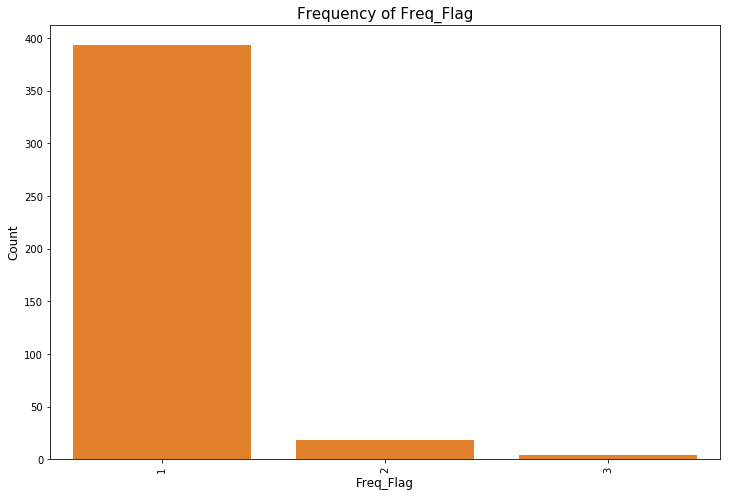

In [119]:
plt.figure(figsize=(12,8))
sns.countplot(x='Freq_Flag', data=Cust_freq_count_NY, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Freq_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Freq_Flag', fontsize=15)
plt.show()

# Monetary Value (M):
The third factor is the amount of money these customers have spent on purchases. Customers who have spent higher contribute more value to the business as compared to those who have spent less. To tag the customers on the basis of monetary flag, we will take country wise sum of Total price for each customer and then filter out the customers of California.

In [120]:
#Calculating the Sum of total monetary purchase for each customer

Cust_monetary = df.groupby(['State','CustomerID'])['Total_Price'].aggregate('sum').\
reset_index().sort_values('Total_Price', ascending=False)
Cust_monetary_CA=Cust_monetary[Cust_monetary['State']=='California']

In [121]:
unique_price=Cust_monetary_CA[['Total_Price']].drop_duplicates()
unique_price=unique_price[unique_price['Total_Price'] > 0]
unique_price['monetary_Band'] = pd.qcut(unique_price['Total_Price'], 5)
unique_price=unique_price[['monetary_Band']].drop_duplicates()
unique_price

,monetary_Band
476,"(6154.702, 52608.878]"
623,"(2329.96, 6154.702]"
180,"(881.534, 2329.96]"
694,"(272.691, 881.534]"
202,"(3.983, 272.691]"


In [122]:
def monetary(row):
    if row['Total_Price'] <= 272:
        val = 1
    elif row['Total_Price'] > 272 and row['Total_Price'] <= 881:
        val = 2
    elif row['Total_Price'] > 881 and row['Total_Price'] <= 2329:
        val = 3
    elif row['Total_Price'] > 2329 and row['Total_Price'] <= 6154:
        val = 4
    else:
        val = 5
    return val
Cust_monetary_CA['Monetary_Flag'] = Cust_monetary_CA.apply(monetary, axis=1)

C:\Users\ashukla\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [123]:

# Let us check the distribution of Monetary flags:
Cust_monetary_CA.groupby(['Monetary_Flag']).size()

Monetary_Flag
1    119
2    114
3    115
4    114
5    115
dtype: int64

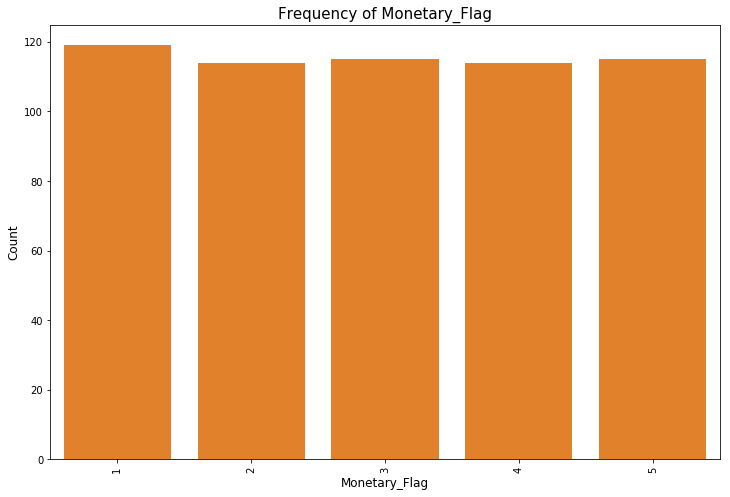

In [124]:

plt.figure(figsize=(12,8))
sns.countplot(x='Monetary_Flag', data=Cust_monetary_CA, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Monetary_Flag', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Frequency of Monetary_Flag', fontsize=15)
plt.show()

In [125]:
# Combining all the three flags :
#Cust_CA_All=pd.merge(Cust_date_CA,Cust_freq_count_CA[['CustomerID','Freq_Flag']],\
#on=['CustomerID'],how='left')
Cust_CA_All=pd.merge(Cust_monetary_CA,Cust_monetary_CA[['CustomerID','Monetary_Flag']],\
on=['CustomerID'],how='left')


Cust_CA_All.head(10)

,State,CustomerID,Total_Price,Monetary_Flag_x,Monetary_Flag_y
0,California,KF-16285,52608.8780,5,5
1,California,NP-18700,48794.8275,5,5
2,California,KC-16540,43523.4200,5,5
3,California,KL-16645,41886.4900,5,5
4,California,JW-15220,39636.4860,5,5
5,California,MS-17365,32883.4420,5,5
6,California,KH-16510,32753.0710,5,5
7,California,ME-17320,29184.9200,5,5
8,California,SC-20230,27751.1260,5,5
9,California,RW-19540,27413.9560,5,5


# Analysis Report
Based on business requirements, various cut-offs are imposed on each of the three parameters. After applying the cut-offs, customers can be classified mainly in three segments:

Customers clearing all the three cut-offs are the best and the most reliable customers. Business should focus on making customised promotional strategies and loyalty schemes for these customers in order to retain this valuable customer base.
Customers failing the recency criterion only are those customers who have stopped visiting the store. Business should focus on these customers and look out for the reason why they abandoned visiting the stores.
Customers clearing the recency criterion but failing frequency criterion are the new customers. Business should provide more incentives and offers to these customers and try to retain these new customers. Apart from segmenting customers, business can also use RFM criterion to filter out a reliable customer base and perform analysis like Market Basket Analysis to see customer buying pattern or assess the success of marketing strategies by analysing the response of these customers.